# Planar data classification with one hidden layer

In this exercise I will implement a 2-class classification neural network with one hidden layer. I will be using np.tanh() as my non-linear activation function for the hidden layer and sigmoid (function imported from `nn_utils.py`) for the 2-class classification output layer. I will be building helper functions to compute cross entropy loss, as well as, forward and backward propagation with respective gradients for sigmoid and tanh functions.  
> Note: No regularization is added at this stage.


In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model
from nn_utils import plot_decision_boundary, sigmoid
%matplotlib inline

# 1 - Dataset 

I will first be loading the dataset I'll be working on and transposing it to be able to fit it to my neural network.

In [2]:
N = 350
np.random.seed(2021)
moons = sklearn.datasets.make_moons(n_samples=N, noise=.2)
X, Y = moons[0], moons[1]

To prepare the data for input into our neural network we will need it transposed in order to get the following shape. n denotes the number of features and m is the number of examples:

<center><img src='transposed.PNG' width='600'></center>

Note:
- Our model will take a numpy array as input.
- The shape of X and Y is different when compared to other models implemented by libraries like ScikitLearn.

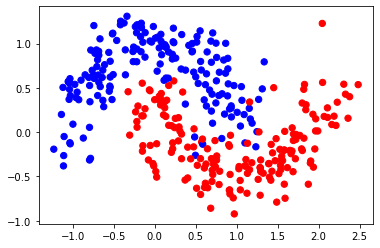

In [3]:
# Transpose X and Y
X, Y = X.T, Y.reshape(1, -1)

# Visualize the data with red (label y=0) and blue (y=1):
plt.scatter(X[0, :], X[1, :], c=Y.T, s=40, cmap='bwr');

## 3 - Setting a Benchmark

To set a benchmark before building a neural network, we will check how logistic regression performs on this classification problem. We could have alternatively done a DummyClassifier. Since the dataset is not linearly separable (see the decision boundary below), logistic regression doesn't perform well (accuracy of 84%). We will see if we can improve this accuracy by our two-layer neural network.

In [4]:
# Train the logistic regression classifier
lr = sklearn.linear_model.LogisticRegressionCV();
lr.fit(X.T, Y.T);

C:\Users\artan\miniconda3\envs\573\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


You can now plot the decision boundary of these models! Run the code below.

Accuracy of logistic regression: 84 % 


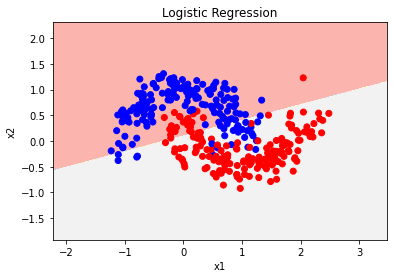

In [5]:
# Plot the decision boundary
plot_decision_boundary(lambda x: lr.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = lr.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ')

## 3 - Neural Network model
For one example $x^{(i)}$ (inspired by deeplearning.ai):
$$z^{[1] (i)} =  W^{[1]} x^{(i)} + b^{[1]}$$  
$$a^{[1] (i)} = \tanh(z^{[1] (i)})$$  
$$z^{[2] (i)} = W^{[2]} a^{[1] (i)} + b^{[2]}$$  
$$\hat{y}^{(i)} = a^{[2] (i)} = \sigma(z^{ [2] (i)})$$  
$$y^{(i)}_{prediction} = \begin{cases} 1 & \mbox{if } a^{[2](i)} > 0.5 \\ 0 & \mbox{otherwise } \end{cases}$$  

Given the predictions on all the examples, we compute the cost $J$ as follows:  
$$J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large\left(\small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right)  \large  \right) \small $$

The general methodology to build a Neural Network is to:  
1. Define the neural network structure ( # of input units,  # of hidden units, etc). 
2. Initialize the model's parameters
3. Loop:
    - Implement forward propagation
    - Compute loss
    - Implement backward propagation to get the gradients
    - Update parameters (gradient descent)

I will build helper functions to compute steps 1-3, then merge them into one function called `nn_model()`. Once `nn_model()` has learned the right parameters, we can make predictions on new data.

### 3.1 - Initializing the parameters ####

Given the size of input, hidden and output layers we will initialize the weights matrices with random values. We will apply a multiplier of 0.01 to get values densely centered around zero. We will initialize the bias vectors as zeros. 

In [6]:
def initialize_parameters(n_x, n_h, n_y, multiplier=0.01):
    """
    Parameters
    ----------
    n_x : int
        size of the input layer
    n_h : int
        size of the hidden layer
    n_y : int
        size of the output layer
    multiplier : float
        multiplier to reduce the scope of initialized parameters
    
    Returns
    -------
    parameters : dictionary 
        containing parameters:
                    W1: weight matrix of shape (n_h, n_x)
                    b1: bias vector of shape (n_h, 1)
                    W2: weight matrix of shape (n_y, n_h)
                    b2: bias vector of shape (n_y, 1)
    """    
    W1 = np.random.randn(n_h, n_x) * multiplier
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * multiplier
    b2 = np.zeros((n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

### 3.2 - Forward propagation

We will compute $Z^{[1]}, A^{[1]}, Z^{[2]}$ and $A^{[2]}$ (the vector of all predictions on all the examples in the training set). Values needed in the backpropagation are stored in "cache". The cache will be given as an input to the next (backpropagation) function. The numbers in square brackets show the layer number.

$$Z^{[1]} =  W^{[1]} X + b^{[1]}$$ 
$$A^{[1]} = \tanh(Z^{[1]})$$
$$Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$$
$$\hat{Y} = A^{[2]} = sigmoid(Z^{[2]})$$

In [7]:
def forward_propagation(X, parameters):
    """
    Parameters
    ----------
    X: 2d-array
        input data of size (n_x, m)
    parameters : dictionary 
        containing parameters W1, b1, W2, b2
    
    Returns
    -------
    A2: 2d-array
        The sigmoid output of the second activation
    cache: dictionary 
        containing Z1, A1, Z2 and A2
    """
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
        
    # Forward Propagation
    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)
    
    assert A2.shape == (1, X.shape[1])
    
    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

### 3.3 - Computing the Cost

Now that we have calculated $A^{[2]}$, we can compute the cost function as follows:  

$$J = - \frac{1}{m} \sum\limits_{i = 1}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} \small$$

**Vectorization**

We are using vectorization (matrix multiplication) to compute the cost function in one take. Alternatively, in a two step computation a dot product of the two vectors could be calculated and then summed to get the cost. We are using `np.squeeze()` to remove redundant dimensions and also cast the array as a type `float`.

In [8]:
def compute_cost(A2, Y):
    """
    Computes the cross-entropy cost
    
    Parameters
    ----------
    A2: 2d-array
        The sigmoid output of the second activation, of shape (1, number of examples)
    Y: 2d-array
        "true" labels vector of shape (1, number of examples)

    Returns
    -------
    cost: float
        cross-entropy cost
    """
    
    m = Y.shape[1] # number of examples

    # Compute cross-entropy cost
    cost = -1/m * (np.dot(np.log(A2), Y.T) + np.dot((1 - Y), np.log(1 - A2).T))
    
    cost = float(np.squeeze(cost))  # turns 1 by 1 array into float 
    
    return cost

### 3.4 - Backpropagation

Using the cache computed during forward propagation, we will implement backward propagation. Except shown by $*$ which denotes elementwise multiplication, the rest of the computations are matrix multiplications.
- Gradients in respect to Sigmoid() function:

$$\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } = \frac{1}{m} (a^{[2](i)} - y^{(i)})$$

$$\frac{\partial \mathcal{J} }{ \partial W_2 } = \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } a^{[1] (i) T} $$

$$\frac{\partial \mathcal{J} }{ \partial b_2 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)}}}$$

- Gradients in respect to tanh() function:

$$\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} } =  W_2^T \frac{\partial \mathcal{J} }{ \partial z_{2}^{(i)} } * ( 1 - a^{[1] (i) 2}) $$

$$\frac{\partial \mathcal{J} }{ \partial W_1 } = \frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)} }  X^T $$

$$\frac{\partial \mathcal{J} _i }{ \partial b_1 } = \sum_i{\frac{\partial \mathcal{J} }{ \partial z_{1}^{(i)}}}$$


In [9]:
def backward_propagation(parameters, cache, X, Y):
    """
    Implement the backward propagation using the instructions above.
    
    Parameters
    ----------
    parameters: dictionary
        containing parameters W1, W2
    cache: dictionary
        containing Z1, A1, Z2 and A2.
    X: 2d-array
        input data of size (n_x, m)
    Y: 2d-array
        "true" labels vector of shape (1, number of examples)
    
    Returns
    -------
    grads: dictionary 
        containing gradients with respect to different parameters
    """
    m = X.shape[1]
    
    # Retrieve W1 and W2 from the parameters
    W1 = parameters['W1']
    W2 = parameters['W2']
        
    # Retrieve also A1 and A2 from cache
    A1 = cache['A1']
    A2 = cache['A2']
    
    # Backward propagation
    dZ2 = A2 - Y
    dW2 = 1/m * np.dot(dZ2, A1.T)
    db2 = 1/m * np.sum(dZ2, axis=1, keepdims=True)
    
    # g_1'(z) = 1 - A1 ** 2
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2))
    dW1 = 1/m * np.dot(dZ1, X.T)
    db1 = 1/m * np.sum(dZ1, axis=1, keepdims=True)
    
    
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}
    
    return grads

See below for description of the notation of partial derivatives used in the function above:  
- dW1 = $\frac{\partial \mathcal{J} }{ \partial W_1 }$  
- db1 = $\frac{\partial \mathcal{J} }{ \partial b_1 }$  
- dW2 = $\frac{\partial \mathcal{J} }{ \partial W_2 }$  
- db2 = $\frac{\partial \mathcal{J} }{ \partial b_2 }$  

### 3.5 - Update Parameters 

We will use dW1, db1, dW2 and db2 from backpropagation in order to update W1, b1, W2 and b2 using the function below.

$$\theta = \theta - \alpha \frac{\partial J }{ \partial \theta }$$  
where $\alpha$ is the learning rate and $\theta$ represents a parameter.


In [10]:
def update_parameters(parameters, grads, alpha=1):
    """
    Updates parameters using the gradient descent update rule
    
    Parameters
    ----------
    parameters: dictionary 
        containing parameters W1, b1, W2, b2 
    grads: dictionary 
        containing gradients 
    alpha: float
        learning rate for gradient update
    
    Returns
    -------
    parameters: dictionary 
        containing updated parameters 
    """
    # Retrieve a copy of each parameter from parameters.
    W1 = copy.deepcopy(parameters['W1'])
    b1 = parameters['b1']
    W2 = copy.deepcopy(parameters['W2'])
    b2 = parameters['b2']
    
    # Retrieve each gradient from grads
    dW1 = grads['dW1']
    db1 = grads['db1']
    dW2 = grads['dW2']
    db2 = grads['db2']
    
    # Update rule for each parameter
    W1 -= alpha * dW1
    b1 -= alpha * db1
    W2 -= alpha * dW2
    b2 -= alpha * db2
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

### 3.6 - nn_model

We will integrate all above functions in `nn_model()` :


In [11]:
def nn_model(X, Y, n_h, n_iter = 10_000, verbose=False, alpha=1, multiplier=0.01):
    """
    Parameters
    ----------
    X: 2d-array
        input data of size (n_x, m)
    Y: 2d-array
        "true" labels vector of shape (1, number of examples)
    n_h: int 
        size of the hidden layer
    n_iter: int 
        Number of iterations in gradient descent loop
    verbose: boolean
        if True, print the cost every 1000 iterations
    alpha : float
        learning rate for weights update
    multiplier : float
        multiplier to shrink the scope of initiated random parameters
    
    Returns
    -------
    parameters: dictionary
        parameters learnt by the model.
    """
    
    np.random.seed(2021)
    n_x = X.shape[0]
    n_y = Y.shape[0]
    
    # Initialize parameters
    parameters = initialize_parameters(n_x, n_h, n_y, multiplier=multiplier)
    
    # Looping gradient descent
    for i in range(0, n_iter):
        # Forward propagation
        A2, cache = forward_propagation(X, parameters)
        
        # Cost function
        cost = compute_cost(A2, Y)
 
        # Backpropagation
        grads = backward_propagation(parameters, cache, X, Y)
 
        # Gradient descent parameter update. Inputs: "parameters, grads". Outputs: "parameters".
        parameters = update_parameters(parameters, grads, alpha)
        
        # Print the cost every 1000 iterations
        if verbose and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters


## 4 - Testing the Model

### 4.1 - Predict

<a name='ex-9'></a>
We will use forward propagation to predict results with our learned weights and biases.

$y_{prediction} = \begin{cases}
      1 & \text{if}\ activation > 0.5 \\
      0 & \text{otherwise}
    \end{cases}$  
    

In [12]:
def predict(parameters, X):
    """
    Predicts a class for each example in X using the learned parameters
    
    Parameters
    ----------
    parameters: dictionary 
        containing your parameters 
    X: 2d-array
        input data of size (n_x, m)
    
    Returns
    -------
    predictions: 2d-arrary 
        vector of predictions of the model of shape (1, m)
    """
    threshold = 0.5
    # Compute probabilities using forward propagation 
    A2, cache = forward_propagation(X, parameters)
    
    # Classify to 0/1 using the threshold.
    predictions = A2 > threshold
    
    return predictions

### 5.2 - Test the Model on the Dataset

We will run the model and see how it performs on our dataset. We are assuming a single hidden layer of $n_h$ hidden units!

Cost after iteration 0: 0.693152
Cost after iteration 1000: 0.312397
Cost after iteration 2000: 0.101547
Cost after iteration 3000: 0.094054
Cost after iteration 4000: 0.093169
Cost after iteration 5000: 0.092703
Cost after iteration 6000: 0.092266
Cost after iteration 7000: 0.091695
Cost after iteration 8000: 0.089755
Cost after iteration 9000: 0.087245


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

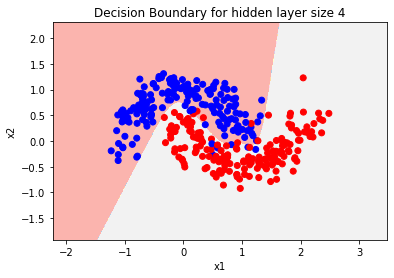

In [13]:
# Build a model
parameters = nn_model(X, Y, n_h = 4, n_iter = 10_000, verbose=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [14]:
# Print accuracy
predictions = predict(parameters, X)
print ('Accuracy: %d' % float((np.dot(Y, predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size) * 100) + '%')

Accuracy: 96%


We have a 12% improvement in accuracy compared to Logistic Regression. The model has learned the lunar patterns! 

## 5 - Tuning hidden layer size

Accuracy for 1 hidden units: 84.57142857142857 %
Accuracy for 2 hidden units: 84.57142857142857 %
Accuracy for 3 hidden units: 96.57142857142857 %
Accuracy for 4 hidden units: 96.85714285714285 %
Accuracy for 5 hidden units: 96.85714285714285 %
Accuracy for 10 hidden units: 96.85714285714285 %
Accuracy for 20 hidden units: 95.71428571428572 %


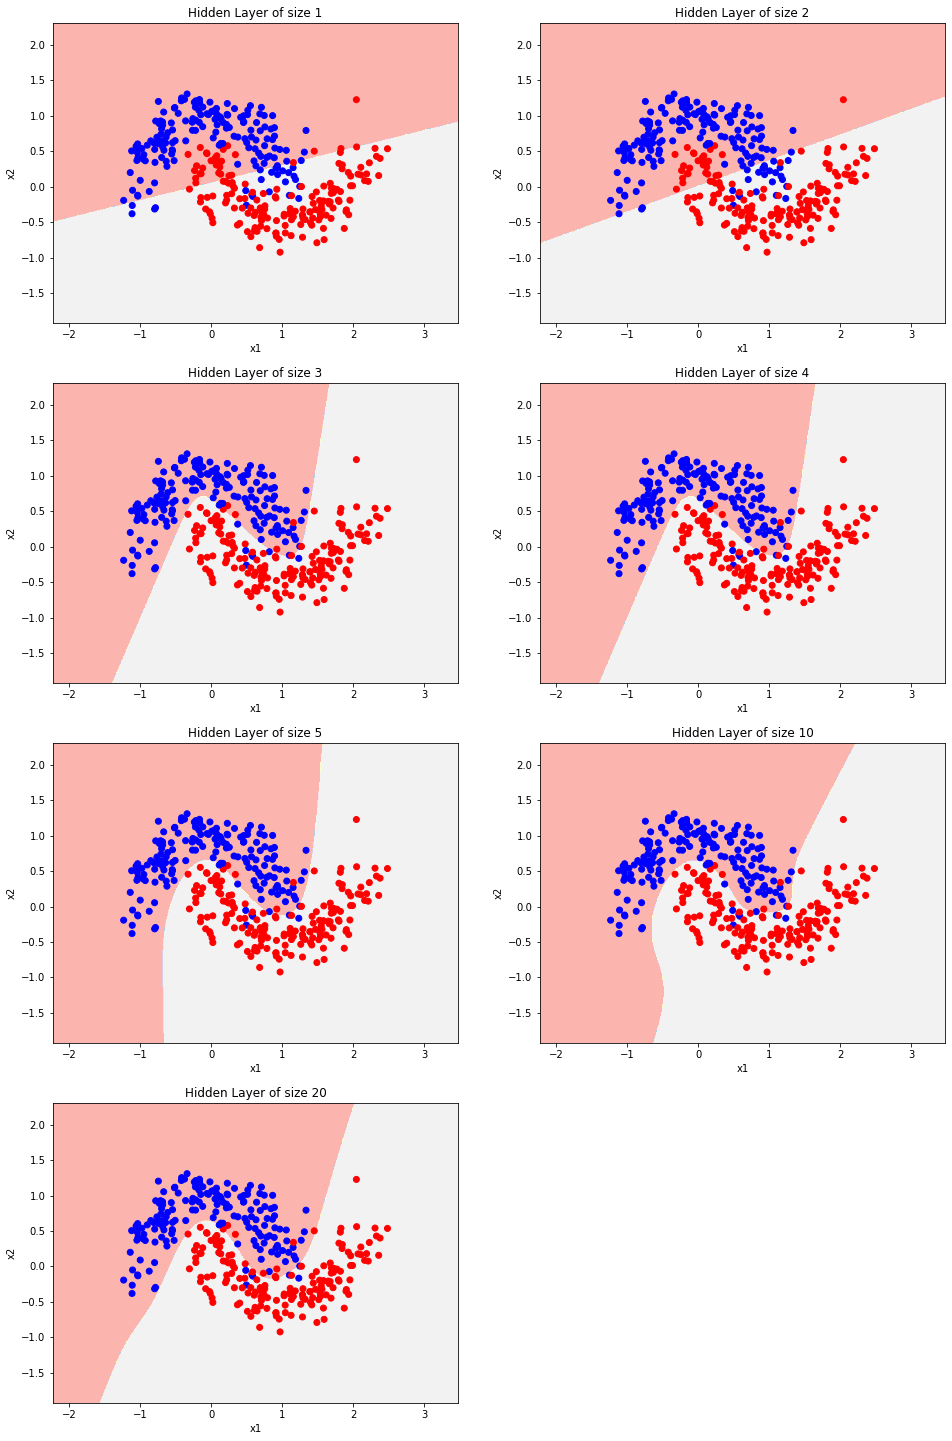

In [15]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 10, 20]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, n_iter = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T) + np.dot(1 - Y, 1 - predictions.T)) / float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

**Interpretation**:
- The larger models (with more hidden units) are able to fit the training set better, until eventually the largest models overfit the data. 
- The best hidden layer size seems to be around n_h = 4 after which we don't see any improvement in accuracy.